In [1]:
from google.colab import files

uploaded = files.upload()  # Choose DiseaseAndSymptoms.csv and Disease precaution.csv


Saving Disease precaution.csv to Disease precaution.csv
Saving DiseaseAndSymptoms.csv to DiseaseAndSymptoms.csv


In [2]:
import os

print(os.listdir())


['.config', 'DiseaseAndSymptoms.csv', 'Disease precaution.csv', 'sample_data']


In [3]:
import pandas as pd

df = pd.read_csv("DiseaseAndSymptoms.csv")
df.head()


,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
symptom_cols = [col for col in df.columns if col.startswith("Symptom_")]
print(symptom_cols)


['Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4', 'Symptom_5', 'Symptom_6', 'Symptom_7', 'Symptom_8', 'Symptom_9', 'Symptom_10', 'Symptom_11', 'Symptom_12', 'Symptom_13', 'Symptom_14', 'Symptom_15', 'Symptom_16', 'Symptom_17']


In [5]:
import json

data = []

for _, row in df.iterrows():
    # Join all symptoms into one text string
    symptoms = []
    for col in symptom_cols:
        value = row[col]
        if pd.notna(value):
            symptoms.append(str(value).replace("_", " ").strip())

    symptoms_text = ", ".join(symptoms)
    disease = row["Disease"]

    entry = {
        "instruction": "Identify the disease pattern based on symptoms.",
        "input": symptoms_text,
        "output": (
            f"Disease: {disease}\n"
            f"Explanation: These symptoms frequently match {disease} patterns in the dataset.\n"
            "Note: This is not medical or diagnostic advice. Consult a real doctor for health concerns."
        )
    }

    data.append(entry)

print("Example training entry:")
print(json.dumps(data[0], indent=2))
print("Total entries created:", len(data))


Example training entry:
{
  "instruction": "Identify the disease pattern based on symptoms.",
  "input": "itching, skin rash, nodal skin eruptions, dischromic  patches",
  "output": "Disease: Fungal infection\nExplanation: These symptoms frequently match Fungal infection patterns in the dataset.\nNote: This is not medical or diagnostic advice. Consult a real doctor for health concerns."
}
Total entries created: 4920


In [6]:
import random

# Shuffle the full dataset in-place
random.shuffle(data)

# 80% for training, 20% for testing
split_idx = int(0.8 * len(data))
train = data[:split_idx]
test = data[split_idx:]

print("Train size:", len(train))
print("Test size:", len(test))


Train size: 3936
Test size: 984


In [7]:
import json

with open("train.jsonl", "w") as f:
    for item in train:
        f.write(json.dumps(item) + "\n")

with open("test.jsonl", "w") as f:
    for item in test:
        f.write(json.dumps(item) + "\n")

print("Saved files: train.jsonl and test.jsonl")


Saved files: train.jsonl and test.jsonl


In [8]:
import os

print(os.listdir())


['.config', 'DiseaseAndSymptoms.csv', 'test.jsonl', 'train.jsonl', 'Disease precaution.csv', 'sample_data']


In [9]:
!pip install -q transformers datasets peft bitsandbytes accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 13.6 MB/s eta 0:00:00


In [10]:
from datasets import load_dataset

train_ds = load_dataset("json", data_files="train.jsonl")["train"]
test_ds = load_dataset("json", data_files="test.jsonl")["train"]

print(train_ds[0])
print("Train size:", len(train_ds))
print("Test size:", len(test_ds))


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

{'instruction': 'Identify the disease pattern based on symptoms.', 'input': 'vomiting, headache, nausea, spinning movements, loss of balance, unsteadiness', 'output': 'Disease: (vertigo) Paroymsal  Positional Vertigo\nExplanation: These symptoms frequently match (vertigo) Paroymsal  Positional Vertigo patterns in the dataset.\nNote: This is not medical or diagnostic advice. Consult a real doctor for health concerns.'}
Train size: 3936
Test size: 984


In [11]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # public, no token required

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
)

print("Model loaded successfully.")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded successfully.


In [12]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 2,252,800 || all params: 1,102,301,184 || trainable%: 0.2044


In [13]:
from datasets import load_dataset

train_ds = load_dataset("json", data_files="train.jsonl")["train"]
test_ds = load_dataset("json", data_files="test.jsonl")["train"]

print("Train size:", len(train_ds))
print("Test size:", len(test_ds))
print(train_ds[0])


Train size: 3936
Test size: 984
{'instruction': 'Identify the disease pattern based on symptoms.', 'input': 'vomiting, headache, nausea, spinning movements, loss of balance, unsteadiness', 'output': 'Disease: (vertigo) Paroymsal  Positional Vertigo\nExplanation: These symptoms frequently match (vertigo) Paroymsal  Positional Vertigo patterns in the dataset.\nNote: This is not medical or diagnostic advice. Consult a real doctor for health concerns.'}


In [14]:
def format_example(example):
    text = (
        f"Instruction: {example['instruction']}\n"
        f"Input: {example['input']}\n"
        f"Output: {example['output']}"
    )
    return {"text": text}

formatted_train = train_ds.map(format_example)
formatted_test = test_ds.map(format_example)

print(formatted_train[0]["text"])


Map:   0%|          | 0/3936 [00:00<?, ? examples/s]

Map:   0%|          | 0/984 [00:00<?, ? examples/s]

Instruction: Identify the disease pattern based on symptoms.
Input: vomiting, headache, nausea, spinning movements, loss of balance, unsteadiness
Output: Disease: (vertigo) Paroymsal  Positional Vertigo
Explanation: These symptoms frequently match (vertigo) Paroymsal  Positional Vertigo patterns in the dataset.
Note: This is not medical or diagnostic advice. Consult a real doctor for health concerns.


In [15]:
def tokenize_function(example):
    return tokenizer(
        example["text"],
        truncation=True,
        max_length=512,
        padding="max_length"
    )

tokenized_train = formatted_train.map(tokenize_function, batched=True)
tokenized_test = formatted_test.map(tokenize_function, batched=True)

# Remove the original text + fields we don't need for training
tokenized_train = tokenized_train.remove_columns(["instruction", "input", "output", "text"])
tokenized_test = tokenized_test.remove_columns(["instruction", "input", "output", "text"])

import torch
tokenized_train.set_format("torch")
tokenized_test.set_format("torch")

print(tokenized_train[0]["input_ids"][:20])


Map:   0%|          | 0/3936 [00:00<?, ? examples/s]

Map:   0%|          | 0/984 [00:00<?, ? examples/s]

tensor([    1,  2799,  4080, 29901, 13355,  1598,   278, 17135,  4766,  2729,
          373, 25828,  4835, 29889,    13,  4290, 29901,  3961, 11407, 29892])


In [16]:
from transformers import TrainingArguments, Trainer
import torch   # <-- THIS FIXES YOUR ERROR

training_args = TrainingArguments(
    output_dir="./disease-llm-qlora",
    num_train_epochs=2,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    logging_steps=20,

    eval_strategy="epoch",
    save_strategy="epoch",

    fp16=torch.cuda.is_available(),
    report_to="none",
)

def data_collator(features):
    batch = {
        "input_ids": torch.stack([f["input_ids"] for f in features]),
        "attention_mask": torch.stack([f["attention_mask"] for f in features]),
    }
    batch["labels"] = batch["input_ids"].clone()
    return batch

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    data_collator=data_collator,
)

trainer.train()


Epoch,Training Loss,Validation Loss
1,0.035200,0.033051


Epoch,Training Loss,Validation Loss
1,0.035200,0.033051
2,0.018600,0.018624


TrainOutput(global_step=984, training_loss=0.31447456434096505, metrics={'train_runtime': 1658.2021, 'train_samples_per_second': 4.747, 'train_steps_per_second': 0.593, 'total_flos': 2.5071868503392256e+16, 'train_loss': 0.31447456434096505, 'epoch': 2.0})

In [17]:
save_path = "disease_llm_adapter"

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print("Saved fine-tuned adapter to:", save_path)


Saved fine-tuned adapter to: disease_llm_adapter


In [18]:
import torch

def generate_disease_response(symptom_text, max_new_tokens=80):
    instruction = "Identify the disease pattern based on symptoms."
    prompt = (
        f"Instruction: {instruction}\n"
        f"Input: {symptom_text}\n"
        f"Output:"
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.eos_token_id
        )

    full_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return full_text


In [21]:
import torch

model.eval()  # set model to evaluation mode

# Use a small subset of the original test dataset (text form)
small_eval = test_ds.select(range(30))   # 30 examples is enough for a confusion matrix

true_labels = []
pred_labels = []

for i, example in enumerate(small_eval):
    # ----- True disease from ground-truth -----
    gt_line = example["output"].split("\n")[0]   # first line: "Disease: XYZ"
    gt_disease = gt_line.replace("Disease:", "").strip()
    true_labels.append(gt_disease)

    # ----- Model prediction -----
    gen_text = generate_disease_response(example["input"], max_new_tokens=40)

    pred_disease = "Unknown"
    if "Disease:" in gen_text:
        try:
            pred_disease = gen_text.split("Disease:")[1].split("\n")[0].strip()
        except:
            pred_disease = "Unknown"

    pred_labels.append(pred_disease)

    # Progress print so you know it's moving
    if (i + 1) % 5 == 0 or (i + 1) == len(small_eval):
        print(f"Processed {i+1}/{len(small_eval)} examples")

print("Done. Collected labels for:", len(true_labels), "examples.")


Processed 5/30 examples
Processed 10/30 examples
Processed 15/30 examples
Processed 20/30 examples
Processed 25/30 examples
Processed 30/30 examples
Done. Collected labels for: 30 examples.


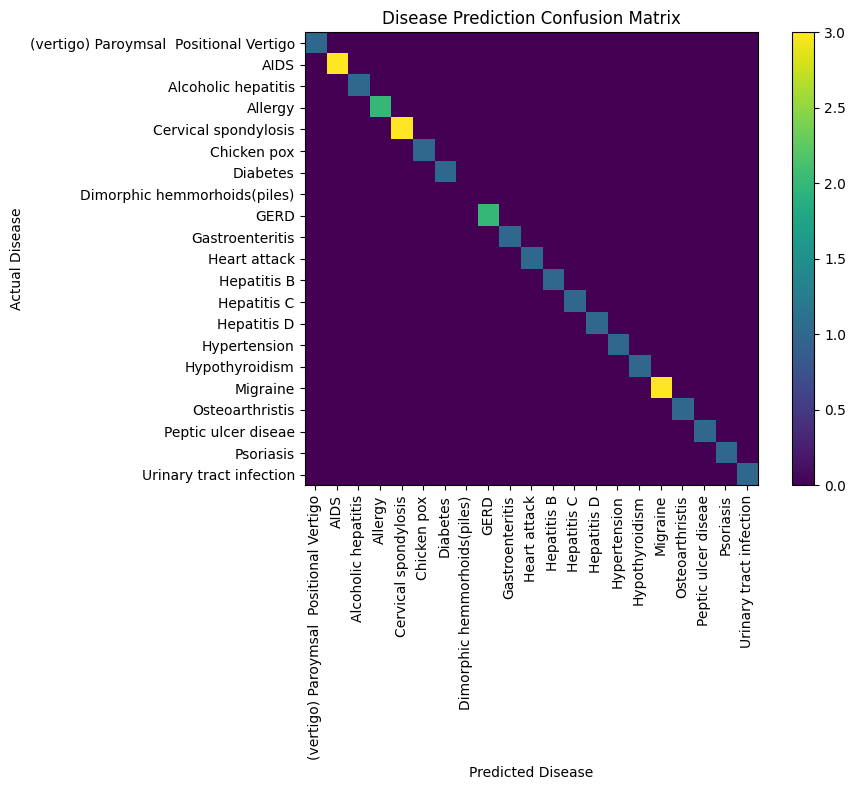

Saved confusion_matrix.png


In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

classes = sorted(list(set(true_labels)))   # unique actual diseases

cm = confusion_matrix(true_labels, pred_labels, labels=classes)

plt.figure(figsize=(10, 8))
im = plt.imshow(cm, interpolation="nearest")
plt.title("Disease Prediction Confusion Matrix")
plt.colorbar(im)

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

plt.xlabel("Predicted Disease")
plt.ylabel("Actual Disease")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=200)
plt.show()

print("Saved confusion_matrix.png")


In [28]:
demo_symptoms = "Fever, headache, body pain"

demo_output = generate_disease_response(demo_symptoms, max_new_tokens=80)
print(demo_output)


Instruction: Identify the disease pattern based on symptoms.
Input: Fever, headache, body pain
Output: Disease: Arthritis
Explanation: These symptoms frequently match Arthritis patterns in the dataset.
Note: This is not medical or diagnostic advice. Consult a real doctor for health concerns.


In [24]:
with open("sample_output_demo_query.txt", "w") as f:
    f.write("Symptoms: Fever, headache, body pain\n\n")
    f.write("Model response:\n")
    f.write(demo_output)

print("Saved: sample_output_demo_query.txt")


Saved: sample_output_demo_query.txt


In [29]:
test_cases = [
    "fever, chills, cough, sore throat",                    # maybe flu / viral
    "abdominal pain, diarrhea, vomiting, loss of appetite", # gastro/intestinal
    "joint pain, swelling, stiffness, fatigue",             # arthritis/rheumatic
]

for i, symptoms in enumerate(test_cases, start=1):
    print(f"\n=== Test case {i} ===")
    print("Symptoms:", symptoms)
    response = generate_disease_response(symptoms, max_new_tokens=80)
    print("Model response:\n", response)
    print("-" * 60)



=== Test case 1 ===
Symptoms: fever, chills, cough, sore throat
Model response:
 Instruction: Identify the disease pattern based on symptoms.
Input: fever, chills, cough, sore throat
Output: Disease: Syndrome: Fever (Temperature)
Explanation: These symptoms frequently match Fever (Temperature) patterns in the dataset.
Note: This is not medical or diagnostic advice. Consult a real doctor for health concerns.
------------------------------------------------------------

=== Test case 2 ===
Symptoms: abdominal pain, diarrhea, vomiting, loss of appetite
Model response:
 Instruction: Identify the disease pattern based on symptoms.
Input: abdominal pain, diarrhea, vomiting, loss of appetite
Output: Disease: Colic
Explanation: These symptoms frequently match Colic patterns in the dataset.
Note: This is not medical or diagnostic advice. Consult a real doctor for health concerns.
------------------------------------------------------------

=== Test case 3 ===
Symptoms: joint pain, swelling, s

In [30]:
with open("sample_output_demo_query.txt", "w") as f:
    f.write("Symptoms: Fever, headache, body pain\n\n")
    f.write("Model response:\n")
    f.write(demo_output)

print("Saved: sample_output_demo_query.txt")


Saved: sample_output_demo_query.txt
